# K-Nearest Neighbor algorithm + VGG
kNN is a popular unsupervised method for classification. Different representation spaces have hugh impact on the accuracy of our kNN classifier. We try to use the last layer of a pretrained deep neural network model to feed the KNN classifier. As comparison, pixels and HoG features was also taken.
The comparison was taken on CIFAR-10.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import torch

from utils import get_cifar10_data

from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import hog


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0)  # set default size of plots

## Load the Data
We will be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for our experiments. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Before running the following block, please run `get_dataset.py`which will download the CIFAR-10 dataset for you.

In [2]:
# Loads the entire CIFAR-10 dataset
# as a dictionary
dataset = get_cifar10_data()

# Check the shape of the data.
print("Training Set Data  Shape: ", dataset['x_train'].shape)
print("Training Set Label Shape: ", dataset['y_train'].shape)
print("Test Set Data  Shape: ", dataset['x_test'].shape)
print("Test Set Label Shape: ", dataset['y_test'].shape)

# Split the data into train and test sets.
x_train = dataset['x_train']
y_train = dataset['y_train']
x_test = dataset['x_test']
y_test = dataset['y_test']

# These are pre-computed channel wise mean and the standard deviation for the CIFAR-10 dataset.
mu = np.array([0.5071, 0.4867, 0.4408])
std = np.array([0.2675, 0.2565, 0.2761])

# Creating mean and standard deviation images
# the deep neural network model
mu_img = np.zeros((3, 32, 32), dtype=np.float32)
std_img = np.zeros((3, 32, 32), dtype=np.float32)
for i in range(mu.shape[0]):
    mu_img[i, ...] = mu[i]
    std_img[i, ...] = std[i]

num_train_samples = x_train.shape[0]
num_test_samples = x_test.shape[0]

Training Set Data  Shape:  (50000, 3072)
Training Set Label Shape:  (50000,)
Test Set Data  Shape:  (10000, 3072)
Test Set Label Shape:  (10000,)


### Visualize the Data

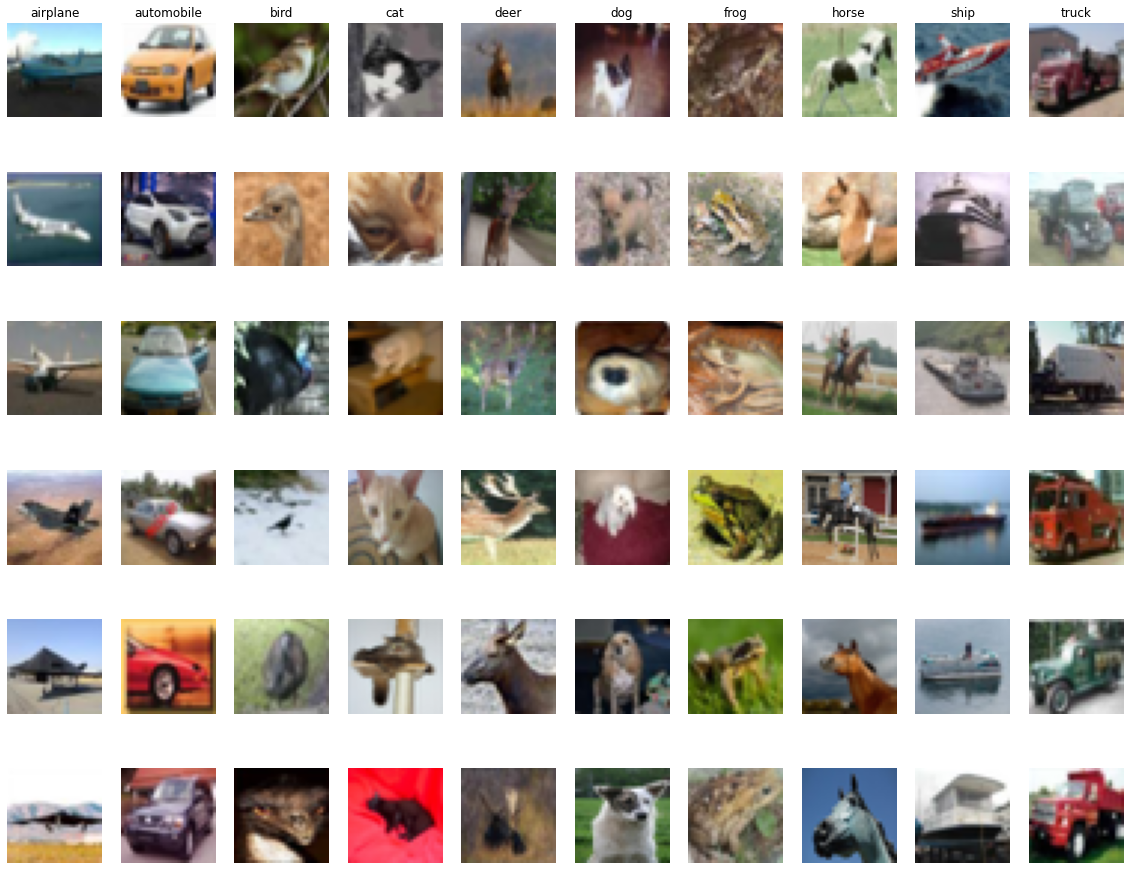

In [3]:
# The 10 CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 6 # How many images to show per class

def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
      idxs = np.flatnonzero(y_train == y)
      idxs = np.random.choice(idxs, samples_per_class, replace=False)
      for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dataset[idx]/255.0)
        plt.axis('off')
        if i == 0:
          plt.title(cls)
    plt.show()

# Visualize the 10 classes
visualize_data(x_train.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1), classes[0:10], samples_per_class)

## KNN on Raw Images
KNN on raw Images. k=1

========== Raw pixel representation ==========
Raw pixel Training Set Data Shape:  (50000, 3072)
Raw pixel Test Set Data Shape:  (10000, 3072)
result of KNN algorithm:
correct: 353 / 1000
wrong: 647 / 1000
first 10 correct and wrong:
             correct       1       2       3       5      12      19      21      29      30      40
           its class       8       8       0       6       5       6       0       6       6       4
   corret's neighbor   42768   21298   37867   16603    8398   42145   41164    3712   49261   46506
           its class       8       8       0       6       5       6       0       6       6       4
               wrong       0       4       6       7       8       9      10      11      13      14
           its class       3       6       1       6       3       1       0       9       7       9
    wrong's neighbor   47188    1881   38805     910   24810   12544   45115   21298   33824   28049
           its class       4       4       4       2       

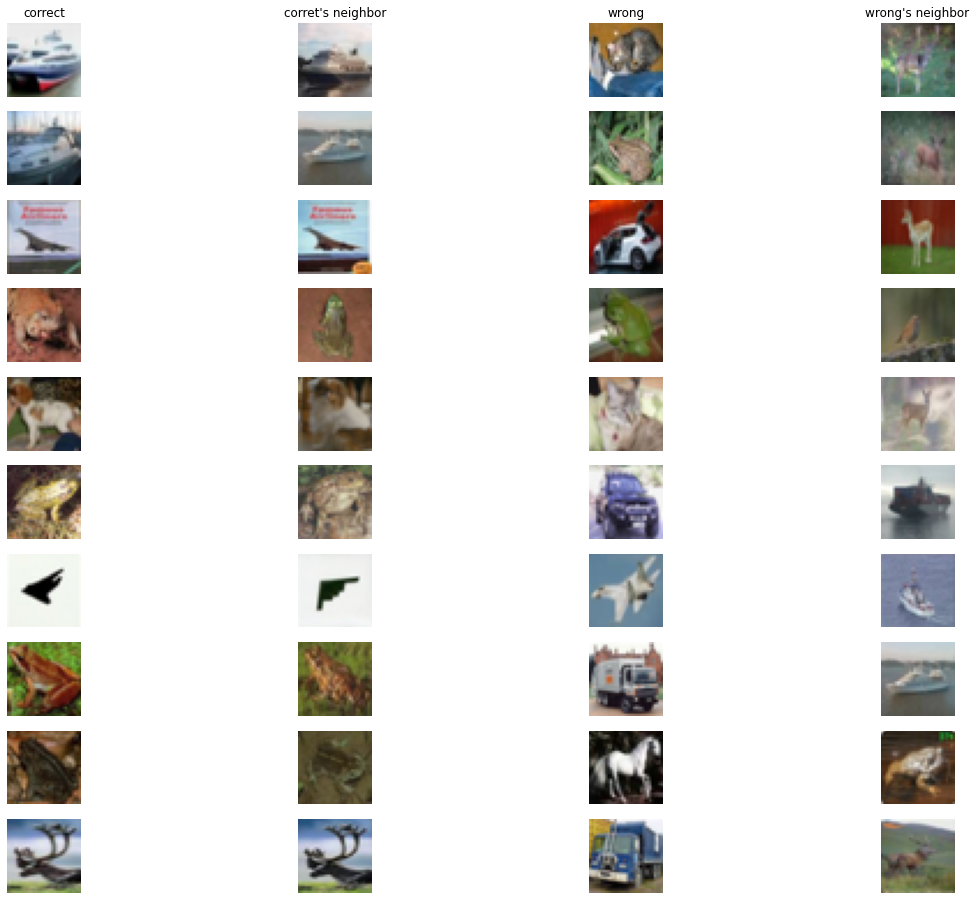

In [4]:
test_set = x_test.reshape(len(x_test), 3, 32, 32).transpose(0, 2, 3, 1)
train_set = x_train.reshape(len(x_train), 3, 32, 32).transpose(0, 2, 3, 1)
def showimage_result(idx):
    """
    according to the result(correct/wrong),show the image result
    Args:
        data:
        idx:

    Returns:

    """
    classes = ['correct', 'corret\'s neighbor', 'wrong', 'wrong\'s neighbor']
    num_classes = len(classes)
    for i in range(4):
        cls = classes[i]
        for j in range(len(idx[i])):
            plt_idx = j * num_classes + i + 1
            plt.subplot(10, num_classes, plt_idx)
            if i%2==0: # test set
                plt.imshow(test_set[idx[i][j]] / 255.0)
            else: # train set, its neighbor
                plt.imshow(train_set[idx[i][j]] / 255.0)
            plt.axis('off')
            if j == 0:
                plt.title(cls)
    plt.show()

def result_table(data):
    classes = ['correct','its class', 'corret\'s neighbor','its class', 'wrong','its class', 'wrong\'s neighbor','its class']
    for team, row in zip(classes, data):
        format_row = "{:>20}" + "{:>8}" * len(row)
        print(format_row.format(team, *row))

from sklearn.neighbors import KDTree
def KNN_show(train_x, train_y, test_x, test_y):
    """
    do the KNN algorithm with first 1000(maybe all if time permit)
    Args:
        train_x:
        train_y:
        test_x:
        test_y:
    Returns:
    """
    T = len(test_x)
    tree = KDTree(train_x, leaf_size=2)
    dist, index = tree.query(test_x[:T], k=1)
    index = [index[i][0] for i in range(len(index))]
    corr_i = []
    corr_cls=[]
    err_i = []
    err_cls=[]
    corr_near = []
    corr_near_cls=[]
    err_near = []
    err_near_cls=[]
    for i in range(T):
        if train_y[index[i]] == test_y[i]:
            corr_i.append(i)
            corr_near.append(index[i])
            corr_cls.append(test_y[i])
            corr_near_cls.append(train_y[index[i]])
        else:
            err_i.append(i)
            err_near.append(index[i])
            err_cls.append(test_y[i])
            err_near_cls.append(train_y[index[i]])
    print("result of KNN algorithm:")
    print("correct:",len(corr_i),"/",len(test_x))
    print("wrong:",len(err_i),"/",len(test_x))
    print("first 10 correct and wrong:")
    res_satis=[corr_i[:10],corr_cls[:10], corr_near[:10],corr_near_cls[:10], err_i[:10],err_cls[:10], err_near[:10],err_near_cls[:10]]
    result_table(res_satis)
    print("show the picture")
    idx = [corr_i[:10], corr_near[:10], err_i[:10], err_near[:10]]
    showimage_result(idx)


# Raw pixel representation, essential k-neareast neighbor
print("=" * 10, "Raw pixel representation", "=" * 10)
print("Raw pixel Training Set Data Shape: ", x_train.shape)
print("Raw pixel Test Set Data Shape: ", x_test.shape)
# KNN_show(x_train[:1000], y_train[:1000], x_test[:100], y_test[:100]) # test
# KNN_show(x_train, y_train, x_train[:100], y_train[:100]) # check
KNN_show(x_train, y_train, x_test[:1000], y_test[:1000])


## KNN using HOG Features
KNN on HOG (Histogram of Oriented Gradients) features. k=1

In [5]:
hog_train_features = list()
for i in range(num_train_samples):
    fd = hog(x_train.reshape(-1, 3, 32, 32)[i].transpose(1, 2, 0), orientations=8, pixels_per_cell=(4, 4),
                  cells_per_block=(1, 1), feature_vector=True, channel_axis=-1)
    hog_train_features.append(fd)
    
hog_test_features = list()
for i in range(num_test_samples):
    fd = hog(x_test.reshape(-1, 3, 32, 32)[i].transpose(1, 2, 0), orientations=8, pixels_per_cell=(4, 4),
                  cells_per_block=(1, 1), feature_vector=True, channel_axis=-1)
    hog_test_features.append(fd)
    
hog_train_features = np.array(hog_train_features)
hog_test_features = np.array(hog_test_features)

========== Histogram-of-gradients(HOG) feature ==========
HOG Training Set Data Shape:  (50000, 512)
HOG Test Set Data Shape:  (10000, 512)
result of KNN algorithm:
correct: 371 / 1000
wrong: 629 / 1000
first 10 correct and wrong:
             correct       3       5      15      19      23      26      27      29      31      40
           its class       0       6       8       6       9       4       0       6       5       4
   corret's neighbor   37867   46951   16086   25039   29519    6027   29735   16153   12556   46506
           its class       0       6       8       6       9       4       0       6       5       4
               wrong       0       1       2       4       6       7       8       9      10      11
           its class       3       8       8       6       1       6       3       1       0       9
    wrong's neighbor     526   37689    3567    9979   28600   12787   14291   29465   13143   43694
           its class       4       1       6       2       4  

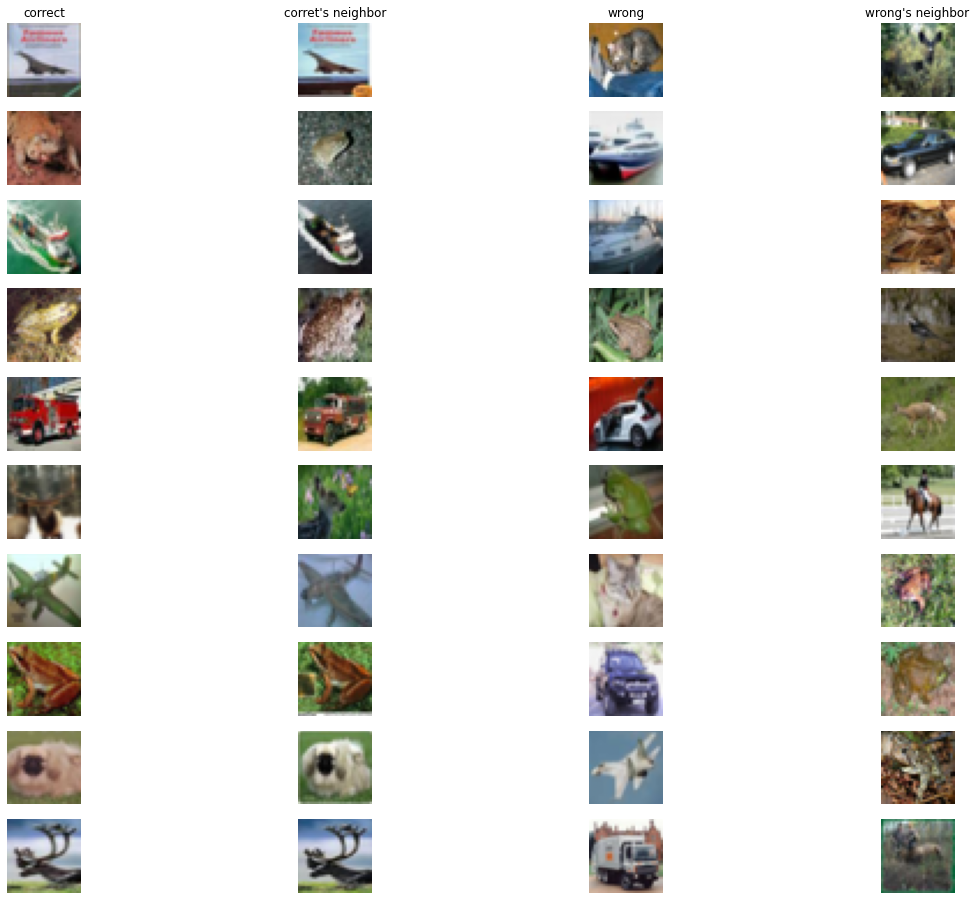

In [6]:
# Histogram-of-gradients(HOG) feature
print("=" * 10, "Histogram-of-gradients(HOG) feature", "=" * 10)
print("HOG Training Set Data Shape: ", hog_train_features.shape)
print("HOG Test Set Data Shape: ", hog_test_features.shape)
# KNN_show(hog_train_features[:1000], y_train[:1000], hog_test_features[:100], y_test[:100]) # test
# KNN_show(hog_train_features, y_train, hog_train_features[:100], y_train[:100]) # check
KNN_show(hog_train_features, y_train, hog_test_features[:1000], y_test[:1000])

## KNN using Deep Neural Network Features
KNN on Deep Neural Network Features extracted by [VGG11](https://arxiv.org/abs/1409.1556).  k=1

In [7]:
from cifar10_models.vgg import vgg11_bn

# Loads the VGG11 model with pre-trained weights on CIFAR-10
deep_model = vgg11_bn(pretrained=True)
deep_model.eval() # will disable gradient calculation to speed up the forward pass

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
def normalize(X, mu = None, std = None):
    # Divide by 255 to make the values of the image array in [0, 1]
    X /= 255.0
    
    if std is None:
        std = np.std(X,axis =0)
    if mu is None:
        mu = np.mean(X,axis =0)
    
    # Normalize
    return (X-mu)/std

In [9]:
x_deep_features_train = []

bsize = 100 # For computing features in batches to reduce total time taken to run.

x_train_ = normalize(np.copy(x_train).reshape(-1, 3, 32, 32).astype(np.float32), mu_img, std_img)
x_test_ = normalize(np.copy(x_test).reshape(-1, 3, 32, 32).astype(np.float32), mu_img, std_img)


for i in range(num_train_samples//bsize):
    x_deep_features_train.append(
        deep_model(torch.tensor(x_train_[i*bsize : (i+1)*bsize])).detach().numpy())

x_deep_features_train = np.array(x_deep_features_train).reshape(num_train_samples, -1) # train features

num_samples = x_test.shape[0]
x_deep_features_test = []
for i in range(num_test_samples//bsize):
    x_deep_features_test.append(
        deep_model(torch.tensor(x_test_[i*bsize :(i+1)*bsize])).detach().numpy())

x_deep_features_test = np.array(x_deep_features_test).reshape(num_test_samples, -1) # test features

========== second-last layer feature of Neural network ==========
Neural Network Training Set Data Shape:  (50000, 512)
Neural Network Test Set Data Shape:  (10000, 512)
result of KNN algorithm:
correct: 9200 / 10000
wrong: 800 / 10000
first 10 correct and wrong:
             correct       0       1       2       3       4       5       6       7       8       9
           its class       3       8       8       0       6       6       1       6       3       1
   corret's neighbor   39108   21432   48158   21975   23152   12824   43825    2866   30784   34700
           its class       3       8       8       0       6       6       1       6       3       1
               wrong      37      57      58      61      87     112     128     147     164     165
           its class       1       7       4       3       7       6       5       2       8       4
    wrong's neighbor   22950   48243   19085   46690   35007   30746   14574   36962   35725   11467
           its class       9 

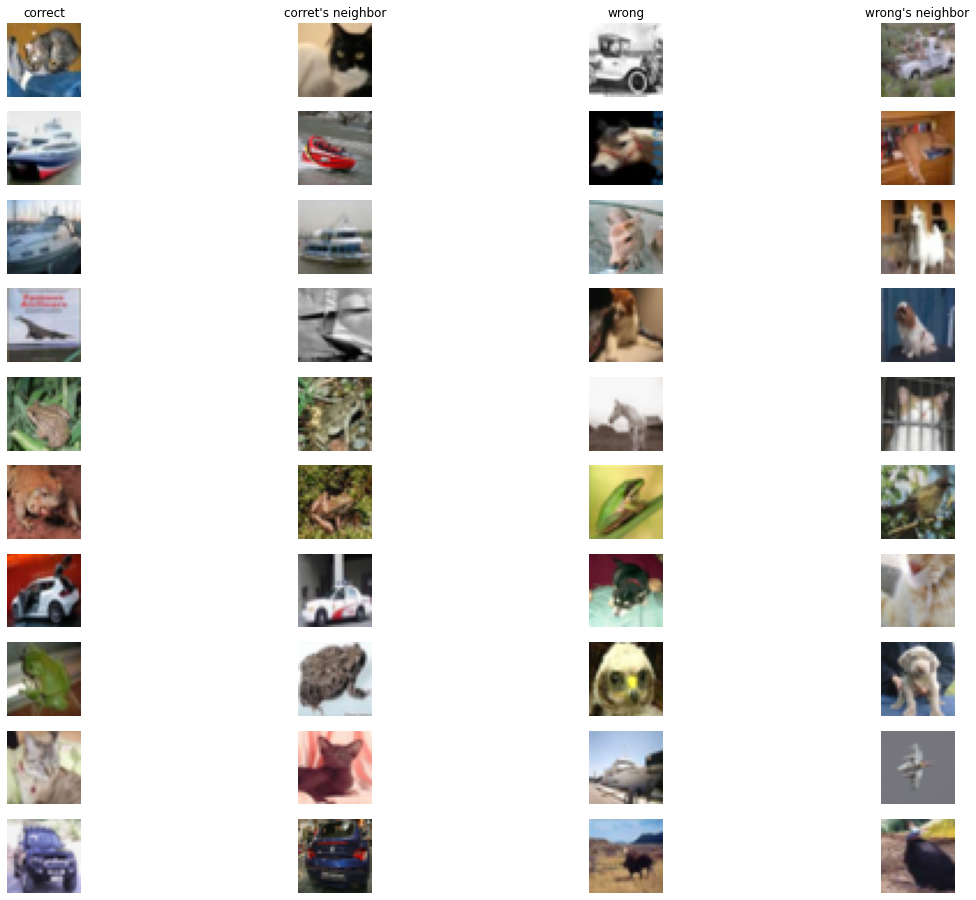

In [10]:
# second-last layer feature of Neural network
print("=" * 10, "second-last layer feature of Neural network", "=" * 10)
print("Neural Network Training Set Data Shape: ", x_deep_features_train.shape)
print("Neural Network Test Set Data Shape: ", x_deep_features_test.shape)
# KNN_show(x_deep_features_train[:1000], y_train[:1000], x_deep_features_test[:100], y_test[:100]) # test
# KNN_show(x_deep_features_train, y_train, x_deep_features_train, y_train) # check
KNN_show(x_deep_features_train, y_train, x_deep_features_test, y_test)